In [1]:
"""
Function to compute Avalanche images

Expects full file path to resting state 4D nifti image
Currently, output images will be written to wd
"""

from __future__ import absolute_import, division, print_function
import numpy as np
import nibabel as nib
import os as os
from scipy.ndimage.measurements import label
from scipy.stats import zscore
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.masking import unmask
from scipy.ndimage.morphology import generate_binary_structure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



Load EPI data

In [7]:
func_file = '/Users/dlurie/Dropbox/Projects/avalanche/avalanche/data/ds000133/sub-01_ses-pre_task-rest_run-01_bold_space-MNI152NLin2009cAsym_clean_std_fwhm6.nii.gz'

In [8]:
func_img = nib.load(func_file)
func_data = func_img.get_data()

Load mask

In [9]:
mask_file = '/Users/dlurie/Dropbox/Projects/avalanche/avalanche/data/ds000133/sub-01_ses-pre_task-rest_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'

In [10]:
mask_img = nib.load(mask_file)

Mask EPI data

In [11]:
func_data_masked = apply_mask(func_img, mask_img)

In [12]:
func_img.shape

(49, 58, 49, 145)

In [13]:
func_data_masked.shape

(145, 28533)

Plot masked EPI data

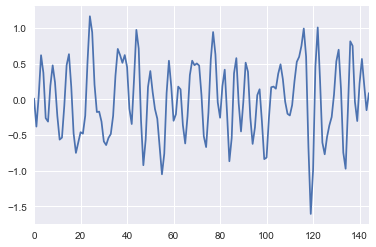

In [14]:
sns.tsplot(func_data_masked[:,1])

Z-score masked data and plot it

In [15]:
func_data_masked_z = zscore(func_data_masked, axis=0)

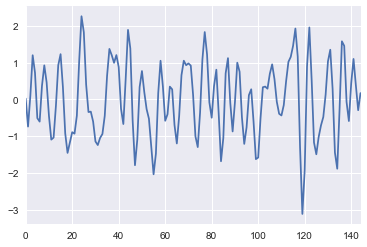

In [16]:
sns.tsplot(func_data_masked_z[:,1])

Threshold and get our points.

In [17]:
thresh = 1.0 # Should be float

In [18]:
pp_data_masked = func_data_masked_z >= 1

In [19]:
pp_data_masked = pp_data_masked.astype('int8')

Unmask the point process data.

In [20]:
pp_img = unmask(pp_data_masked, mask_img)

In [21]:
pp_img.shape

(49, 58, 49, 145)

In [22]:
np.unique(pp_data_masked)

array([0, 1], dtype=int8)

In [49]:
pp_img.to_filename('/Users/dlurie/Dropbox/Projects/avalanche/avalanche/data/ds000133/results/sub-01_ses-pre_task-rest_run-01_bold_space-MNI152NLin2009cAsym_variant-clean_std_fwhm6_ppimage.nii.gz')

Get 4D clusters

In [23]:
connectivity = 4

In [24]:
struct = generate_binary_structure(4,connectivity)

In [25]:
pp_data = pp_img.get_data()

In [26]:
cluster_data, num_clusters = label(pp_data, struct)

In [27]:
num_clusters

1106

In [28]:
cluster_data.shape

(49, 58, 49, 145)

In [29]:
cluster_img = nib.Nifti1Image(cluster_data, pp_img.affine)

In [69]:
cluster_img.to_filename('/Users/dlurie/Dropbox/Projects/avalanche/avalanche/data/ds000133/results/sub-01_ses-pre_task-rest_run-01_bold_space-MNI152NLin2009cAsym_variant-clean_std_fwhm6_clusterimage.nii.gz')

Get the size of the label image

In [91]:
(n_x, n_y, n_z, n_t) = cluster_img.shape

Mask the cluster image to create a 2D array.

In [39]:
cluster_data_masked = apply_mask(cluster_img, mask_img)

In [40]:
cluster_data_masked.shape

(145, 28533)

In [93]:
#initialize matrix to count uniques:
uMat = np.zeros(shape=(num_clusters, n_t))

In [94]:
uMat.shape

(1106, 145)

In [95]:
#loop through each time point and identify cluster members:
for i in range(n_t):
    #determine uniques at this time point:
    inds = np.unique(cluster_data_masked[i,:])
    #Note: 0 will always be a unique value, and we don't
    #actually care about zeros, so ignore them:
    uMat[(inds[1:].astype('int')-1),i] = 1

In [96]:
uMat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  1.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [97]:
#now the uMat matrix is populated with indicators for each of the "avalanches"
#but we need to determine which are truly avalanches (i.e., occur in more than
#one time point), and which are not
avarray= np.zeros((uMat.shape[0], n_t+1))
#fill this with binary data:
avarray[:,1:]= uMat
#and take the difference:
avarray[:,1:] = np.diff(avarray, axis=1)
#and then take it again to identify 1 to -1 (diff==-2) points - these are not 
#avalanches!!!
tmparray = np.diff(avarray, axis=1)

In [98]:
#now we can efficiently remove all fake avalanches:
fakes = np.asarray(np.where(np.sum(tmparray==-2,axis=1)))+1
cluster_data[np.isin(cluster_data,fakes)]=0 

In [99]:
#now single time point clusters should be removed
#and we want to regenerate our labels:
cluster_data, num_clusters = label(cluster_data, struct)

In [ ]:
cluster_img = nb.Nifti1Image(cluster_data, header=func_img.header, affine=func_img.affine)
    
# Reconstruct the 4D volume
ava_file = os.path.join(os.getcwd(), 'avalancheLabels.nii.gz')
img_new.to_filename(ava_file)

In [103]:
def avalanche(func_file, mask_file, thresh, connectivity, out_dir):
    """
    Load and preprocess data.
    """
    # Load the functional image.
    func_img = nib.load(func_file)
    func_data = func_img.get_data()
    
    if mask_file is not None:
        # Load the mask image.
        mask_img = nib.load(mask_file)
    else:
        # Create a new brain mask from the EPI data.
        mask_img = compute_epi_mask(func_img)    
    
    # Mask the functional data
    func_data_masked = apply_mask(func_img, mask_img)
    
    # Z-score the masked functional data.
    func_data_masked_z = zscore(func_data_masked, axis=0)
    
    """
    Create the initial point-process image and 4D cluster image.
    """
    # Apply the threshold and get the point-process data.
    pp_data_masked = func_data_masked_z >= thresh
    
    # Unmask the point-process data, creating an image, and save it.
    pp_img = unmask(pp_data_masked, mask_img)
    pp_img.to_filename(os.path.join(out_dir,'{0}_thresh-{1}_conn-{2}_ppimage.nii.gz'.format(os.path.basename(func_file), str(thresh), str(connectivity))))
    
    # Label 3D and 4D clusters.
    struct = generate_binary_structure(4,connectivity)
    pp_data = pp_img.get_data()
    cluster_data, num_clusters = label(pp_data, struct)
    
    # Create a cluster image and save it.
    cluster_img = nib.Nifti1Image(cluster_data, pp_img.affine)
    cluster_img.to_filename(os.path.join(out_dir,'{0}_thresh-{1}_conn-{2}_clusterimage.nii.gz'.format(os.path.basename(func_file), str(thresh), str(connectivity))))    
    
    """
    Remove clusters that only exist in a single volume.
    """
    # Get the dimensions of the functional image.
    (n_x, n_y, n_z, n_t) = cluster_img.shape
   
    # Mask the cluster image to get a 2D array.
    cluster_data_masked = apply_mask(cluster_img, mask_img)
    
    # Initialize a matrix to count unique clusters in each volume.
    uMat = np.zeros(shape=(num_clusters, n_t))
    
    # loop through each time point and identify cluster members:
    for i in range(n_t):
        #determine uniques at this time point:
        inds = np.unique(cluster_data_masked[i,:])
        #Note: 0 will always be a unique value, and we don't
        #actually care about zeros, so ignore them:
        uMat[(inds[1:].astype('int')-1),i] = 1
        
    #now the uMat matrix is populated with indicators for each of the "avalanches"
    #but we need to determine which are truly avalanches (i.e., occur in more than
    #one time point), and which are not
    avarray= np.zeros((uMat.shape[0], n_t+1))
    #fill this with binary data:
    avarray[:,1:]= uMat
    #and take the difference:
    avarray[:,1:] = np.diff(avarray, axis=1)
    #and then take it again to identify 1 to -1 (diff==-2) points - these are not 
    #avalanches!!!
    tmparray = np.diff(avarray, axis=1)
    
    #now we can efficiently remove all fake avalanches:
    fakes = np.asarray(np.where(np.sum(tmparray==-2,axis=1)))+1
    cluster_data[np.isin(cluster_data,fakes)]=0 
    
    #now single time point clusters should be removed
    #and we want to regenerate our labels:
    cluster_data, num_clusters = label(cluster_data, struct)
    
    # Create an image from the new cluster data (now avalanche data) and then save it.
    cluster_img = nib.Nifti1Image(cluster_data, header=func_img.header, affine=func_img.affine)
    cluster_img.to_filename(os.path.join(out_dir,'{0}_thresh-{1}_conn-{2}_avalancheimage.nii.gz'.format(os.path.basename(func_file), str(thresh), str(connectivity)))) 
    
    """"
    
    img_new = nb.Nifti1Image(labeled_array, header=img.header, affine=img.affine)
    
    # Reconstruct the 4D volume
    ava_file = os.path.join(os.getcwd(), 'avalancheLabels.nii.gz')
    img_new.to_filename(ava_file)
        
    #make a new 4D array that is 1 time point greater than original data:
    transition_array = np.zeros((n_x, n_y, n_z, n_t+1))
    
    #the point process should come from the de-faked avalance data:
    signal = labeled_array
    signal[signal>0]=1
    #fill this transition array with binary data and leave first time point (t[0])
    #empty:
    transition_array[:,:,:,1:] = signal
    
    #take the difference between points across the 4th (time) dimension:
    onset_array = np.diff(transition_array, axis=3)
    onset_array[onset_array==-1] = 0
    #the onset array is back in the same time order and number of time points
    #as the original arrays...
    
    img_new = nb.Nifti1Image(onset_array, header=img.header, affine=img.affine)
    # Reconstruct the 4D volume
    pp_file = os.path.join(os.getcwd(), 'binary_pp.nii.gz')
    img_new.to_filename(pp_file)

    Nvoxels = np.unique(labeled_array, return_counts='true')
    Nvoxels = np.asarray(Nvoxels).T
    #get rid of the 0 count (these aren't avalanches)
    Nvoxels = Nvoxels[1:]
    
    #could return num_features, Nvoxels
    
    """

In [104]:
avalanche(func_file, mask_file, 2, 4, '/Users/dlurie/Dropbox/Projects/avalanche/avalanche/data/ds000133/results/')

In [88]:
np.unique(cluster_data_masked, return_counts=True, return_index=True, axis=0)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  3.],
        ..., 
        [ 3.,  3.,  3., ...,  0.,  3.,  0.],
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 5.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([  0,  90,  96,  89,  49,  48,  95,  94,  84, 119, 121,   8, 110,
         50, 124, 109, 120,  83, 101,  51,  62,  55, 125,  98, 100,  99,
         97, 139,  22,  79,  60,  64,  33, 127,  53,  14,  34, 111,  16,
         63, 112,  10,  57,  52, 143,  27, 142,  31,  30,  85,  66,  65,
        133,  54, 118, 106,  47,  29, 105,  91,   2,   1,  32, 126,  40,
         59, 132,  11, 140,   7,  74,  21,  93,  73,  82, 123,  80, 102,
         61,  20,  92,  19, 104,  35,  67,  81,  88,  70,  69,  71,  18,
         17,  26, 129, 135,  75, 103,  46, 108, 107,  38,  56, 117, 137,
         78,  77,  58,  23, 113, 141,  76, 122, 116,  39,  68,  44, 136,
        130,  37,  36, 131,  24,  25,  45,

In [85]:
unique, unique_index, unique_counts = np.unique(cluster_data_masked, return_counts=True, return_index=True)

(array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.10400000e+03,   1.10500000e+03,   1.10600000e+03], dtype=float32),
 array([      0,   85599,  256797, ...,  827447, 1883169, 2682093]),
 array([3509108,       4,       1, ...,       1,       2,       1]))

In [76]:
unique_counts

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [73]:
np.unique(unique[2])

array([    0.,     3.,   127.,   149.,   566.,  1057.,  1076.], dtype=float32)

In [82]:
np.__version__

'1.12.1'